#IST664/CIS668 - Homework 4 Template

##My name: Shubham Sharma

By adding your name to the space above, you attest that this work is all your own, except in those code and text blocks where you have given attribution to another author. You do not need to provide attribution for code copied from the labs or exercises for this class.

Sometimes it is helpful to discuss the homework with other members of the class. This is fine as long as you do not share code. If you collaborated with one or more individuals, list their names here:

###My collaborators: __________

For this homework, you will be processing a dataset that contains a series of short texts, each of which is separated by a semicolon. The goal for the homework is to develop a representation of the relationships among these sentences that can be processed by a CNN to make predictions.

This template helps to pre-process the data with the following steps:

1. Parse the data into sentences.
2. Develop a vector summary for each sentence.
3. Create a matrix of similarities among the sentences.
4. Pad the matrix to a common (square) size. This will be the input to the CNN.
5. Convert input matrices and output vectors into tensors.


# 1. Preparing the data

In [1]:
import pandas as pd
import gensim
import numpy as np
import keras
import keras.layers as L
import re
from collections import Counter
from sklearn.model_selection import train_test_split

# Read in the data from Github
url = "https://raw.githubusercontent.com/jmstanto/ist664/main/SentenceDBfeb2022.csv"

sentDB = pd.read_csv(url)

sentDB.shape

(288, 13)

In [2]:
sentDB # Preview the data

,EntryNum,LogCPY,Alpha,LogJIF,NumSent,Texts,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,1,1.634385657,0.89,0.382017,8,Sleep induction (time it takes you to fall asl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.763427994,0.85,0.880242,5,It is exciting to figure out new ways to solve...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.763427994,0.72,0.880242,4,Establishing a new company excites me.; Owning...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.763427994,0.77,0.880242,4,I really like finding the right people to mark...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1.932746869,0.93,0.771587,6,"If I should find myself in a jam, I could thin...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,301,0.301029996,0.97,0.017033,55,I can make online educational media (animation...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284,302,0.301029996,0.97,0.017033,30,I can make online educational media (animation...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,303,0.301029996,0.97,0.017033,7,I can enrich my lesson content by using electr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,304,0.301029996,0.93,0.017033,12,I can mathematically express the solution ways...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# These are the three metrics you will predict
print(type(sentDB["LogCPY"])) # The log of cites per year
print(type(sentDB["Alpha"])) # The alpha value
print(type(sentDB["LogJIF"])) # The log of the journal impact factor

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [4]:
cols = ['LogCPY', 'Alpha', 'LogJIF', 'Texts', 'NumSent']
sentDB = sentDB[cols]
sentDB.dtypes

# LogCPY is an object. That suggests it might have some bad values or missing values. 

LogCPY      object
Alpha      float64
LogJIF     float64
Texts       object
NumSent      int64
dtype: object

In [5]:
# Checking for missing values
sentDB.isna().sum()

# There are no missing values in our response variables.

LogCPY     0
Alpha      0
LogJIF     0
Texts      0
NumSent    0
dtype: int64

In [6]:
sentDB['LogCPY'].unique()
# We can see a bad value '#NUM!'. Removing those rows.

array(['1.634385657', '1.763427994', '1.932746869', '2.136958255',
       '2.329360208', '1.916878271', '1.739730529', '1.213707447', '0',
       '1.052529051', '0.728041452', '1.073107098', '2.598172973',
       '1.56769109', '0.072550667', '0.301029996', '-0.041392685',
       '-0.602059991', '0.124938737', '0.646263654', '0.814501272',
       '1.909049038', '2.452512748', '2.414005217', '1.112030158',
       '0.331843943', '0.189056236', '0.864261199', '1.845718018',
       '0.445522269', '1.354321904', '0.023481096', '0.118099312',
       '1.095109204', '0.911362513', '1.106164736', '0.568891628',
       '0.77815125', '0.643452676', '0.196294645', '1.120260474',
       '1.164919081', '0.257564302', '0.672867202', '0.194574665',
       '-0.28254659', '0.851937465', '0.91498921', '0.583576586',
       '0.515579507', '0.761760834', '0.698970004', '0.841202996',
       '1.62324929', '0.716003344', '1.634908903', '1.118689787',
       '0.447158031', '0.686380877', '1.766625268', '1.2023

In [7]:
sentDB = sentDB.loc[sentDB.LogCPY != '#NUM!'] 
sentDB.shape

# We have removed 4 rows from our dataframe

(284, 5)

In [8]:
# Changing the datatype of LogCPY to float.
sentDB['LogCPY'] = sentDB.LogCPY.astype(float)

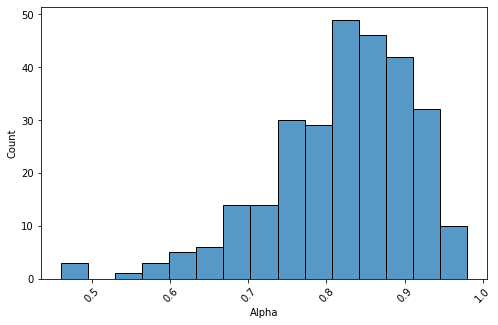

In [9]:
# Task: Produce histograms for each the three metric outcome variables

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (8,5))
sns.histplot(data = sentDB, x = sentDB["Alpha"])
plt.xticks(rotation = 45)
plt.show()

We can see the Alpha value is left skewed. 

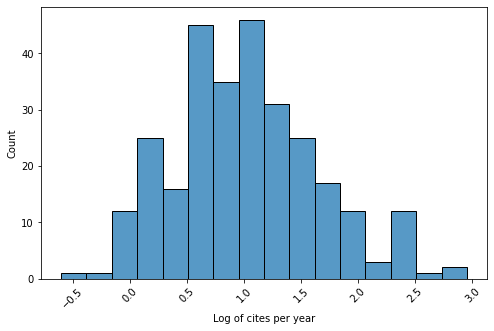

In [10]:
plt.figure(figsize = (8,5))
sns.histplot(data = sentDB, x = sentDB["LogCPY"])
plt.xticks(rotation = 45)
plt.xlabel('Log of cites per year')
plt.show()

Log of Cites per year is approximately a bell shaped curve.

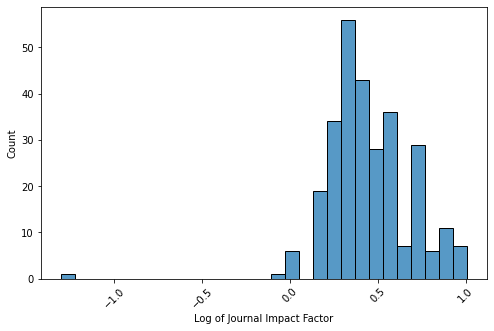

In [11]:
plt.figure(figsize = (8,5))
sns.histplot(data = sentDB, x = sentDB["LogJIF"])
plt.xticks(rotation = 45)
plt.xlabel('Log of Journal Impact Factor')
plt.show()

Log of Journal impact factor has some outliers with value below -1.0 

In [12]:
# How big does our padded matrix need to be?
max_mat_size = max(sentDB["NumSent"]) + 1
max_mat_size

56

In [13]:
# Finding out the row containing max number of sentences. I realized later I could have used 'NumSent' instead of list comprehension.
max_arg = [np.argmax([len(x.split(';')) for x in sentDB['Texts']])][0]
sentDB.iloc[max_arg]['Texts']

'I can make online educational media (animation, video, educational game).; I can fictionalize an educational media (animation, video, educational game) step by step.; I can make my custom pages on the online platforms I use.; I can customize the software I use by my needs.; I can make a blog or blogs which my students discuss and submit ideas.; I can prepare creative lesson content with mobile devices (smartphone, tablet).; I can write unique scenario for educational media (animation, video, educational game).; I can prepare online interactive lesson presentation.; I can prepare different concept map and drawing on online.; I can build game with online game providers for both educational and fun.; I can design a unique character for educational media (animation, video, educational media).; I can build an online platform to evaluate my students.; I can decide online platforms or simulation development app by lesson content.; I can design a page/platform which students get lesson conten

In [14]:
# Task: Examine a few of the texts.
print(sentDB["Texts"].iloc[0])
print(sentDB["Texts"].iloc[5])

# First sentence is about sleep.
# Fifth sentence is about setting goals and being motivated.

Sleep induction (time it takes you to fall asleep after turning-off the lights); Awakenings during the night; Final awakening earlier than desired; Total sleep duration; Overall quality of sleep (no matter how long you slept); Sense of well-being during the day; Functioning (physical and mental) during the day; Sleepiness during the day
When I make plans, I am certain I can make them work.; One of my problems is that I cannot get down to work when I should. ; If I cant do a job the first time. I keep trying until I can.; When I set important goals for myself, I rarely achieve them.; I give up on things before completing them. ; I avoid facing difficulties. ; If something looks too complicated, I will not even bother to try it. ; When I have something unpleasant to do, I stick to it until I finish it. ; When I decide to do something, I go right to work on it. ; When trying to learn something new, I soon give up if I am not initially successful. ; When unexpected problems occur, I don't 

In [15]:
# We will need the library for loading sentence transformers
# This generates a lot of output, but should run pretty fast.
!pip install sentence-transformers

     |████████████████████████████████| 79 kB 5.5 MB/s 
     |████████████████████████████████| 4.0 MB 34.0 MB/s 
     |████████████████████████████████| 1.2 MB 10.2 MB/s 
     |████████████████████████████████| 77 kB 3.5 MB/s 
     |████████████████████████████████| 895 kB 40.1 MB/s 
     |████████████████████████████████| 6.6 MB 45.8 MB/s 
     |████████████████████████████████| 596 kB 10.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=c47ac049757f47100a9ffb33d6d765a6773ec9fc54686b25c3450f31f961f838
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [16]:
# Now load a pre-trained sentence transformer. There are hundreds to choose from.
# This downloads a lot of data to your virtual machine and takes half a minute or so.
from sentence_transformers import SentenceTransformer

# Here's a sentence transformer model that encodes a d=384 vector. See:
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [17]:
# This defines a function that takes an input matrix and puts it in the
# upper left corner of a standard-sized matrix

import numpy as np

def pad_matrix(in_mat, mat_size):
  ret_mat = np.zeros(shape=(mat_size, mat_size))

  # By using Python negative indices, we can target the upper left subset
  # of the return matrix in the same shape as the input matrix.
  ret_mat[:-(mat_size - in_mat.shape[0]), :-(mat_size - in_mat.shape[1])] = in_mat
  return(ret_mat)

In [18]:
# Test the padder
M = np.arange(3*3).reshape((3,3))
print(M)

pad_matrix(M, 5)

[[0 1 2]
 [3 4 5]
 [6 7 8]]


array([[0., 1., 2., 0., 0.],
       [3., 4., 5., 0., 0.],
       [6., 7., 8., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

## Analyzing padded matrix

In [19]:
# Process the individual texts: Takes about half a minute
from sentence_transformers.util import cos_sim

mat_list = []

for text in sentDB["Texts"]:
  items = text.split(";")
  vect_list = sentence_model.encode(items)  # transforming text in each sentence into a 384 dimensional vector space
  sim_matrix = cos_sim(vect_list, vect_list)
  mat_list.append(pad_matrix(sim_matrix, max_mat_size))

In [20]:
# Should have the same number of matrices as rows in the pandas df
len(mat_list)

284

mat_list is a list for the 284 sentences that we have in our data.

In [21]:
# Task: Review one of the padded matrices. Comment on what you see.

In [22]:
mat_list[0].shape, mat_list[0]  # This is the matrix for the first sentence. 

((56, 56),
 array([[1.00000012, 0.51713705, 0.25663489, ..., 0.        , 0.        ,
         0.        ],
        [0.51713705, 1.00000024, 0.49270099, ..., 0.        , 0.        ,
         0.        ],
        [0.25663489, 0.49270099, 1.00000012, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]))

In [23]:
# View the first text and number of sentences in it.
sentDB.iloc[0]['NumSent'], sentDB.iloc[0]['Texts'] # There are 8 sentences in this text. 

(8,
 'Sleep induction (time it takes you to fall asleep after turning-off the lights); Awakenings during the night; Final awakening earlier than desired; Total sleep duration; Overall quality of sleep (no matter how long you slept); Sense of well-being during the day; Functioning (physical and mental) during the day; Sleepiness during the day')

In [24]:
mat_list[0][0]
# This contains the cosine similarity scores of the first sentence with the other 7 sentences for the text contained in first row of data.

array([1.00000012, 0.51713705, 0.25663489, 0.42713016, 0.38633689,
       0.15928498, 0.25946495, 0.36126399, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [25]:
mat_list[0][1]
# This contains the cosine similarity scores of the second sentence with the other 7 sentences for the text contained in first row of data.

array([0.51713705, 1.00000024, 0.49270099, 0.35162467, 0.36825812,
       0.35767582, 0.38968417, 0.41693851, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [26]:
mat_list[0][8]
# Since there are only 8 sentences in the first row of 'Texts' column, this is just a zero padded array. 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [27]:
# The text containing maximum number of sentences. Here, we have 55 sentences and the cosine similarity of the first sentence with all other sentences.
mat_list[max_arg][0]

array([ 1.        ,  0.66758716,  0.5088104 ,  0.35978127,  0.5644387 ,
        0.58140123,  0.7316677 ,  0.61782455,  0.53941631,  0.7095561 ,
        0.65957177,  0.55903769,  0.63991058,  0.5289185 ,  0.32241708,
        0.37086776,  0.51127696,  0.46203792,  0.42788902,  0.49734813,
        0.40717655,  0.37441605,  0.59458756,  0.49430919,  0.49430919,
        0.50835538,  0.30910334,  0.52853227,  0.25516069,  0.12286848,
        0.49848208,  0.49848208,  0.26456931,  0.48119   ,  0.58044046,
        0.46895397,  0.57617962,  0.24629831,  0.17014343,  0.23941255,
        0.08543335,  0.19593477,  0.19911638, -0.03138067,  0.13987929,
        0.10423396,  0.10423396,  0.10423396,  0.18151224, -0.0234004 ,
        0.08596988,  0.2528832 ,  0.07834218,  0.01595653,  0.39769405,
        0.        ])

mat_list is a list containing cosine similarity scores for a sentence with other sentences in a single row of our data. Since the maximum number of sentences contained in a text is 55, we have padded other cosine similarity scores with zeros to make each feature of same size. 

## Creating Tensors for training 

In [28]:
# Convert matrices into a tensor: This tensor will be the input to your CNN
import tensorflow as tf

sim_tensor = tf.convert_to_tensor(mat_list)

sim_tensor.shape

TensorShape([284, 56, 56])

In [29]:
# These will be your output tensors for each of three separate models
cpy_tensor = tf.convert_to_tensor(sentDB["LogCPY"])
alpha_tensor = tf.convert_to_tensor(sentDB["Alpha"])
jif_tensor = tf.convert_to_tensor(sentDB["LogJIF"])

cpy_tensor.shape, alpha_tensor.shape, jif_tensor.shape

(TensorShape([284]), TensorShape([284]), TensorShape([284]))

# 2. CNN model and training

In [30]:
# Here are a few keras imports that will probably be needed. You can include
# other kinds of layers appropriate to CNNs if you like. 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import MeanSquaredError

To complete the homework, you should now build three separate CNN models, using the similarity matrices as inputs and the three numeric (metric) vectors as outputs. Look to the Week 8 lecture and Lab 8 for information on configuring CNN models. The most basic model you might configure could consist of a 2D convolutional layer (because your input is a set of 2D matrices) followed by a max-pooling-2D layer, followed by a flattening layer, and concluding with a single unit dense layer with linear activation (because you are predicting a metric output rather than a categorical one). You can try more complex models as well.

Don't worry about having a separate dev/test set with a dataset this small, just train each model until you get a stable error level. The resulting models may be somewhat overtrained, but that's OK.

In [31]:
# Some setup parameters that may be helpful
input_shape = (max_mat_size, max_mat_size, 1) # Each input is a single layer square matrix 
num_filters = 8 # You can adjust this up or down to try to improve model fit
pool_size = (3, 3) # You can adjust this up or down as needed to improve model fit

In [32]:
# Since this is a regression problem, we can use 'Linear' activation function.
# Linear results in a numerical value which we require. 

In [33]:
# Configure the layers of your model here using Sequential

model = Sequential()

# adding the first convolution layer
model.add(Conv2D(filters=num_filters, kernel_size=pool_size, input_shape=input_shape, activation = 'linear'))

# Often times, applying a MaxPooling2D operation with a pooling size of more than 2x2 results in a great loss of data, and so 2x2 is a better option to choose.
model.add(MaxPooling2D((2,2)))

# adding second convolution layer
model.add(Conv2D(filters=32, kernel_size=pool_size, activation = 'linear'))
model.add(MaxPooling2D((2,2)))

# Flatten and add a fully-connected Dense layer
model.add(Flatten())
model.add(Dense(20, activation = 'linear'))  # a layer with 20 neurons
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation = 'linear'))   # Final output layer

# Compile and summarize your model here
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss = MeanSquaredError(), optimizer = opt)
print(model.summary())


# defining a functio to fit the model and plot learning curve based on epochs and learning rate. 
def fit_model(trainX, trainy, epochs, lrate):

  model = Sequential()

  # adding the first convolution layer
  model.add(Conv2D(filters=num_filters, kernel_size=pool_size, input_shape=input_shape, activation = 'linear'))
  model.add(MaxPooling2D((2,2)))

  # adding second convolution layer
  model.add(Conv2D(filters=32, kernel_size=pool_size, activation = 'linear'))
  model.add(MaxPooling2D((2,2)))

  # Flatten and add a fully-connected Dense layer
  model.add(Flatten())
  model.add(Dense(20, activation = 'linear'))  # a layer with 20 neurons
  model.add(Dropout(rate=0.5))
  model.add(Dense(1, activation = 'linear'))   # Final output layer

  # Compile and summarize your model here
  opt = tf.keras.optimizers.Adam(learning_rate=lrate)
  model.compile(loss = MeanSquaredError(), optimizer = opt)

	# fit model
  history = model.fit(trainX, trainy, epochs=epochs, verbose=0)
	# plot learning curves
  plt.plot(history.history['loss'], label='train')
  #plt.title('lrate='+str(lrate), pad=-50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        2336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 20)                9

Remember, because you are predicting metric outcomes (i.e., floating point numbers) rather than categories, you should use MeanSquaredError() as your loss function. Make sure to show a model summary that confirms the shapes of the various layers. Exeriment with the learning rate and the number of epochs to make your training as efficient as you can. Once you have a trained model that is satisfactory for each of your outcome variables, make predictions using the model and the original input data and compute a regular correlation coefficient (e.g., with numpy corrcoef) to confirm how well the model performs.

## Training for LogCPY

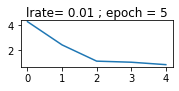

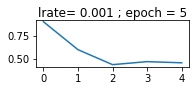

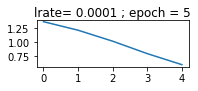

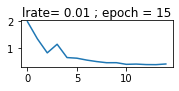

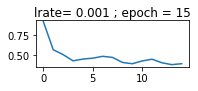

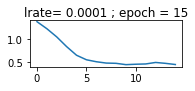

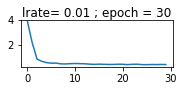

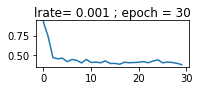

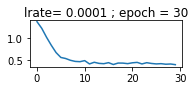

In [34]:
# Train and evaluate your model here
# create learning curves for different learning rates
learning_rates = [1E-2, 1E-3, 1E-4]
epochs = [5,15,30]
for i in range(len(epochs)):
  for j in range(len(learning_rates)):
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.figure(figsize=(6,4))
    plt.subplot(plot_no)
    plt.title(f"lrate= {learning_rates[j]} ; epoch = {epochs[i]}", pad=-50)

    # fit model and plot learning curves for a learning rate
    fit_model(sim_tensor, cpy_tensor, epochs=epochs[i], lrate=learning_rates[j])
# show learning curves
plt.show()

In [35]:
# From above plots and analysis, I have chosen epochs=15 and learning rate as 0.001 to create the final model.

best_model = Sequential()
best_model.add(Conv2D(filters=num_filters, kernel_size=pool_size, padding='valid', activation='linear', input_shape=input_shape))
best_model.add(MaxPooling2D((2,2)))

best_model.add(Flatten())
best_model.add(Dense(20, activation = 'linear'))  # a layer with 20 neurons
best_model.add(Dense(1, activation = 'linear'))   # Final output layer

# Compile
best_model.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Fit and do predictions
best_model.fit(x=sim_tensor, y=cpy_tensor, epochs=15, verbose=0)
cpy_preds = best_model.predict(sim_tensor).squeeze(axis=-1)

# Checking the correlation between true values and predicted values.
cpy_corr = np.corrcoef(cpy_tensor, cpy_preds)
print(cpy_corr)

[[1.         0.38366619]
 [0.38366619 1.        ]]


## Training for LogJIF

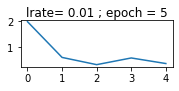

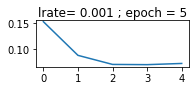

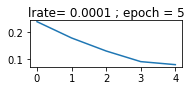

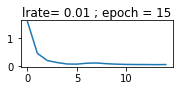

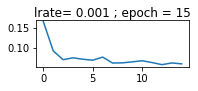

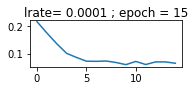

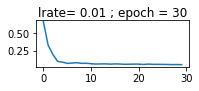

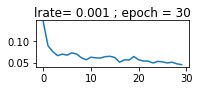

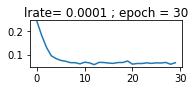

In [36]:
# Train and evaluate your model here
# create learning curves for different learning rates
learning_rates = [1E-2, 1E-3, 1E-4]
epochs = [5,15,30]
for i in range(len(epochs)):
  for j in range(len(learning_rates)):
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.figure(figsize=(6,4))
    plt.subplot(plot_no)
    plt.title(f"lrate= {learning_rates[j]} ; epoch = {epochs[i]}", pad=-50)

    # fit model and plot learning curves for a learning rate
    fit_model(sim_tensor, jif_tensor, epochs=epochs[i], lrate=learning_rates[j])
# show learning curves
plt.show()

In [37]:
# From above plots and analysis, I have chosen epochs=15 and learning rate as 0.001 to create the final model.

best_model = Sequential()
best_model.add(Conv2D(filters=num_filters, kernel_size=pool_size, padding='valid', activation='linear', input_shape=input_shape))
best_model.add(MaxPooling2D((2,2)))

best_model.add(Flatten())
best_model.add(Dense(20, activation = 'linear'))  # a layer with 20 neurons
best_model.add(Dense(1, activation = 'linear'))   # Final output layer

# Compile
best_model.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Fit and do predictions
best_model.fit(x=sim_tensor, y=jif_tensor, epochs=15, verbose=0)
jif_preds = best_model.predict(sim_tensor).squeeze(axis=-1)

# Checking the correlation between true values and predicted values.
jif_corr = np.corrcoef(jif_tensor, jif_preds)
print(jif_corr)

[[1.         0.44334881]
 [0.44334881 1.        ]]


## Training for Alpha

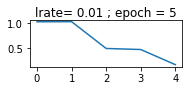

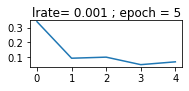

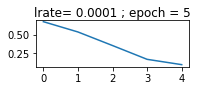

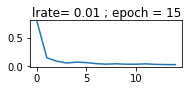

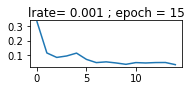

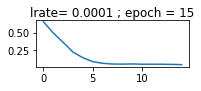

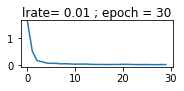

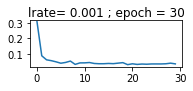

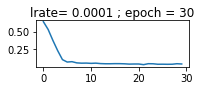

In [38]:
# Train and evaluate your model here
# create learning curves for different learning rates
learning_rates = [1E-2, 1E-3, 1E-4]
epochs = [5,15,30]
for i in range(len(epochs)):
  for j in range(len(learning_rates)):
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.figure(figsize=(6,4))
    plt.subplot(plot_no)
    plt.title(f"lrate= {learning_rates[j]} ; epoch = {epochs[i]}", pad=-50)

    # fit model and plot learning curves for a learning rate
    fit_model(sim_tensor, alpha_tensor, epochs=epochs[i], lrate=learning_rates[j])
# show learning curves
plt.show()

In [40]:
# From above plots and analysis, I have chosen epochs=15 and learning rate as 0.001 to create the final model.

best_model = Sequential()
best_model.add(Conv2D(filters=num_filters, kernel_size=pool_size, padding='valid', activation='linear', input_shape=input_shape))
best_model.add(MaxPooling2D((2,2)))

best_model.add(Flatten())
best_model.add(Dense(20, activation = 'linear'))  # a layer with 20 neurons
best_model.add(Dense(1, activation = 'linear'))   # Final output layer

# Compile
best_model.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Fit and do predictions
best_model.fit(x=sim_tensor, y=alpha_tensor, epochs=15, verbose=0)
alpha_preds = best_model.predict(sim_tensor).squeeze(axis=-1)

# Checking the correlation between true values and predicted values.
alpha_corr = np.corrcoef(alpha_tensor, alpha_preds)
print(alpha_corr)

[[1.         0.54601764]
 [0.54601764 1.        ]]


Don't forget to write a concluding comment that explains what you did and interprets the results. Which of the three outcome variables were you able to predict most accurately?

# 3. Conclusion: 


- Our data consists of sentences seperated by semicolon and 3 features describing those texts. Using a convolutional neural network, we are trying to predict the log of citations per year, alpha value and log of journal impact factor. Each row contains sentences which are related to each other.

- First, we need to convert those texts into some embeddings. For that we have used SentenceTransformer which is Siamese BERT network. Each sentence is mapped to a 384 dimensional dense vector space. Then, we have created a matrix of cosine similarity scores for each sentence with the other sentences in a row of text. That matrix is our input feature.

- Next, I have created a CNN with two convolutional layers and Max pooling to predict 
 - 1. log of cites 
 - 2. log of Journal Impact Factor 
 - 3. Alpha value. 

  I have tried hyperparameter tuning epochs and learning rate. 

- To test how good are the predictions, I found out the correlation coefficient between the true target values and predicted values. Based on the best hyperparameters, we get the highest correlation coefficient (0.54) for Alpha. For LogCPY, the Pearson's correlation coefficients is 0.38 and for LogJIF, the Pearson's correlation coefficients is 0.44. Pearson's correlation is a parametric test and assumes data normality and when I plotted the histograms for predictions, they were approximately normal.

- I have used dropout as a regularizer to reduce overfitting but I still think the models are overfitted and due to a small dataset, we did not succeed in creating a generalized model. 

- I gave a thought about the reasons for different performance on the three predictors but I couldn't think of a valid reason. If possible, could you please write it as a grading feedback?

- I have also tried 3-fold Cross Validation for one of the predictor variables (logCPY) with 50 epochs. When Validation error starts increasing after some epochs, we can say that the model has started to overfit. But it never started going up, although there was not much change in the validation error for each fold after around 15 epochs.

## Doubts:



- We are using the cosine similarity scores as our training input. Is there any particular reason to use them instead of the sentence embeddings. 

- How to decide the number of convolutional layers?

- For Images, CNN is easier to understand than text. In images, we add convolution layers where each filter acts as a feature detector to detect vertical edges, horizontal edges and in the next layers, complex patterns etc. But when we are adding filters for text, what are they exactly trying to detect?

- To understand, if a model is overfitted, we usually check the train and test error vs. epochs curve. When the training error and test error start diverting (test error starts increasing), we know model is being overfitted. But here, we have not defined any test data. When I tried fitting using validation_split=0.2 and plotting the curve, the curve had a wavy pattern and it was not clear to me when to define overfitting.

- I have used different learning rates and epochs and plotted the loss. How can we select what learning rate and epochs to use without using validation data? I know, for epochs, we can see when the loss starts to stagnate and then decide the epochs but how is the best learning rate decided?

- Lastly, what further analysis I could have done to make a more generalized model?

# 4. Experimenting 5-fold for predicting cpy_tensor 

In [55]:
from sklearn.model_selection import KFold

EPOCHS = 50
NUM_FOLDS = 3
LEARNING_RATE = 0.001
loss_per_fold = []

# # Merge inputs and targets
# inputs = np.concatenate((input_train, input_test), axis=0)
# targets = np.concatenate((target_train, target_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=NUM_FOLDS, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(sim_tensor, cpy_tensor):

  model = Sequential()

  # adding the first convolution layer
  model.add(Conv2D(filters=num_filters, kernel_size=pool_size, input_shape=input_shape, activation = 'linear'))

  # Often times, applying a MaxPooling2D operation with a pooling size of more than 2x2 results in a great loss of data, and so 2x2 is a better option to choose.
  model.add(MaxPooling2D((2,2)))

  # adding second convolution layer
  model.add(Conv2D(filters=32, kernel_size=pool_size, activation = 'linear'))
  model.add(MaxPooling2D((2,2)))

  # Flatten and add a fully-connected Dense layer
  model.add(Flatten())
  model.add(Dense(20, activation = 'linear'))  # a layer with 20 neurons
  model.add(Dropout(rate=0.5))
  model.add(Dense(1, activation = 'linear'))   # Final output layer

  # Compile the model
  model.compile(loss=MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=[tf.keras.metrics.MeanSquaredError()])

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(sim_tensor, cpy_tensor,
              epochs=EPOCHS, validation_data=(sim_tensor, cpy_tensor))

  # Generate generalization metrics
  scores = model.evaluate(sim_tensor, cpy_tensor, verbose=0)
  print(f'Score for fold {fold_no}:  {model.metrics_names[1]} of {scores[1]}')
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# Provide average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(loss_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
9/9 [==============================] - 1s 78ms/step - loss: 0.9438 - mean_squared_error: 0.9438 - val_loss: 0.6237 - val_mean_squared_error: 0.6237
Epoch 2/50
9/9 [==============================] - 1s 61ms/step - loss: 0.5027 - mean_squared_error: 0.5027 - val_loss: 0.4854 - val_mean_squared_error: 0.4854
Epoch 3/50
9/9 [==============================] - 1s 60ms/step - loss: 0.5281 - mean_squared_error: 0.5281 - val_loss: 0.3911 - val_mean_squared_error: 0.3911
Epoch 4/50
9/9 [==============================] - 1s 64ms/step - loss: 0.4689 - mean_squared_error: 0.4689 - val_loss: 0.3777 - val_mean_squared_error: 0.3777
Epoch 5/50
9/9 [==============================] - 1s 60ms/step - loss: 0.4273 - mean_squared_error: 0.4273 - val_loss: 0.3649 - val_mean_squared_error: 0.3649
Epoch 6/50
9/9 [==============================] - 1s 62ms/step - loss: 0.4425 - mean_squared_error: 0.4425 -